# Blackjack: A Casino Banking Card Game

<div align="center">
    <img src="./images/blackjack_game.jpeg" width="300" alt="BlackJack Game Environment">
</div>

Blackjack is a card game where the goal is to get as close to a sum of 21 as possible without going over. The player plays against a fixed dealer. The face cards (Jack, Queen, King) have a point value of 10, Aces can count as 1 or 11 (called 'usable' ace when counting as 11) and numeric cards will have a value equal to their number.

An agent learns to make optimal decisions (hit or stand) based on the current game state to maximize its expected rewards.

## The Environment

Environment design for Blackjack in Gynmasium is as follows.

- **States:** Tuple containing player's hand value (int), value of dealer's face-up card (int), whether player holds a usable ace (bool)

- **Discrete Actions:** 0 (stand: keep current hand) or 1 (hit: take another card)

<!-- - **Q-values:** Expected rewards for each action in each state -->

- **Rewards:** +1.5 (for natural blackjack), +1.0 (for win), 0.0 (for draw) or -1.0 (lose) is rewarded at the end of each episode.

- **Episode Termination:** The episode ends when any of the condition holds true:
    - Player's sum goes over 21 (bust)
    - Player decides to stop (stick) [Note: After the player sticks, the dealer reveals their facedown card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins. If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.]
    - Player gets natural blackjack (21 from first two cards)

- **Starting State:** The starting state is initialized for player's hand value within range 4 and 21, dealer's face-up card value within range 1 to 10 and usable ace with either 0 or 1.

**Assumptions:** This verion of implementation assumes an infinite deck considering cards drawn with replacement.

**Sets up the environment**

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [2]:

# Creates the Blackjack environment
env = gym.make('Blackjack-v1')

# Shows environment details
print("Observation Space:", env.observation_space)
print("Action Space:", env.action_space)


Action Space: Discrete(2)
Observation Space: Tuple(Discrete(32), Discrete(11), Discrete(2))


In [6]:
# Resets the environment and record the initial observation
observation, info = env.reset()
print("Initial Observation:")
print(f"Player's hand value: {observation[0]}, dealer's face-up card: {observation[1]}, if Ace is usable: {observation[2]}")

Initial Observation:
Player's hand value: 15, dealer's face-up card: 2, if Ace is usable: 0


## The Agent

Now we'll implement the Q-learning agent with methods for action selection, Q-value updates, and exploration decay. The Q-learning update rule is given by:

$Q(s,a) \leftarrow Q(s,a) + \alpha[R + \gamma \max_{a'} Q(s',a') - Q(s,a)]$

Where:
- $Q(s,a)$: Q-value for state $s$ and action $a$
- $\alpha$: Learning rate (0 to 1)
- $R$: Immediate reward
- $\gamma$: Discount factor (0 to 1)
- $s'$: Next state
- $\max_{a'} Q(s',a')$: Maximum Q-value for next state
- $[R + \gamma \max_{a'} Q(s',a') - Q(s,a)]$: Temporal-difference (TD) error



In [ ]:
class BlackjackAgent:
    """ Q-learning agent for Blackjack environment """
    
    def __init__(self, env, lr=0.01, discount_factor=0.95,
                 initial_epsilon=1.0, epsilon_decay=0.99995, final_epsilon=0.01):
        """
        Initializes the Q-learning agent for Blackjack.
        
        Args:
            env: The Blackjack environment
            lr: How quickly new information overrides old (α)
            discount_factor: How much future rewards are valued (γ)
            initial_epsilon: Starting exploration rate
            epsilon_decay: Rate at which exploration decreases
            final_epsilon: Minimum exploration rate
        """
        self.env = env
        self.lr = lr
        self.discount_factor = discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        
        self.q_table = defaultdict(lambda: np.zeros(env.action_space.n))    # Initializes Q-table with zeros
        

    
    def get_action(self, state):
        """
        Selects an action using ε-greedy policy.
        
        Args:
            state: The current state (player_sum, dealer_card, usable_ace) of the environment
            
        Returns:
            int: The action selected (0: stand, 1: hit)
        """
        if np.random.random() < self.epsilon:       # Explores by sampling a random action
            return self.env.action_space.sample()
        elif np.sum(self.q_table[state]) == 0:      # Also explores by sampling a random action when all Q-values are zero
            return self.env.action_space.sample()
        else:
            return np.argmax(self.q_table[state])
    
    def update_q_value(self, state, action, reward, next_state, done):
        """
        Update Q-value for state-action pair using the Bellman equation.
        
        Args:
            state: Current state
            action: Action taken
            reward: Reward received
            next_state: Next state
            done: Whether episode ended
        """
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + (self.discount_factor * self.q_table[next_state][best_next_action] * (not done))
        td_delta = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.lr * td_delta

        # best_next_value = 0 if done else np.max(self.q_table[next_state])
        # target = reward + self.discount_factor * best_next_value
        # current_q = self.q_table[state][action]
        # self.q_table[state][action] = current_q + self.lr * (target - current_q)
    
    def decay_epsilon(self):
        """Decay exploration rate"""
        self.epsilon = max(self.final_epsilon, self.epsilon * self.epsilon_decay)
    
    def train(self, n_episodes):
        """
        Train the agent for specified number of episodes.
        
        Args:
            n_episodes: Number of episodes to train
        """

        # Tracks performance metrics during training
        training_rewards = []  # Stores rewards per episode
        training_win_rates = []
        training_steps = []   # Stores steps per episode

        wins = 0
        evaluation_interval = n_episodes // 100  # Evaluate every 1% of the training episodes
        
        for episode in range(n_episodes):
            state, _ = self.env.reset()
            state = tuple(state)                    # Convert to tuple for dictionary key
            episode_reward = 0
            episode_steps = 0

            done = False

            while not done:                         # Loops until the episode ends
                action = self.get_action(state)
                next_state, reward, terminated, truncated, _ = self.env.step(action)
                next_state = tuple(next_state)
                
                self.update_q_value(state, action, reward, next_state, terminated or truncated)
                
                state = next_state
                episode_reward += reward
                episode_steps += 1
                done = terminated or truncated
            
            # Update metrics
            training_rewards.append(episode_reward)
            training_steps.append(episode_steps)
            wins += (episode_reward > 0)
            
            # Decay exploration rate
            self.decay_epsilon()
            
            # Calculate and store win rate periodically
            if (episode + 1) % evaluation_interval == 0:
                win_rate = wins / evaluation_interval
                training_win_rates.append(win_rate)
                wins = 0                                    # Reset wins for next interval

        return training_rewards, training_steps, training_win_rates     # Returns training metrics

## Training the Agent

Now let's create and train our Blackjack agent.

In [ ]:
# Create and train the agent
agent = BlackjackAgent(env,
                      lr=0.01,
                      discount_factor=0.95,
                      initial_epsilon=1.0,
                      epsilon_decay=0.99995,
                      final_epsilon=0.01)

# Trains for 100,000 episodes    [Note: This may take several seconds to complete]
training_rewards, training_steps, training_win_rates = agent.train(n_episodes=100000)

### Analyzing Training Progress

Let's create some plots to visualize how the agent learned over time.

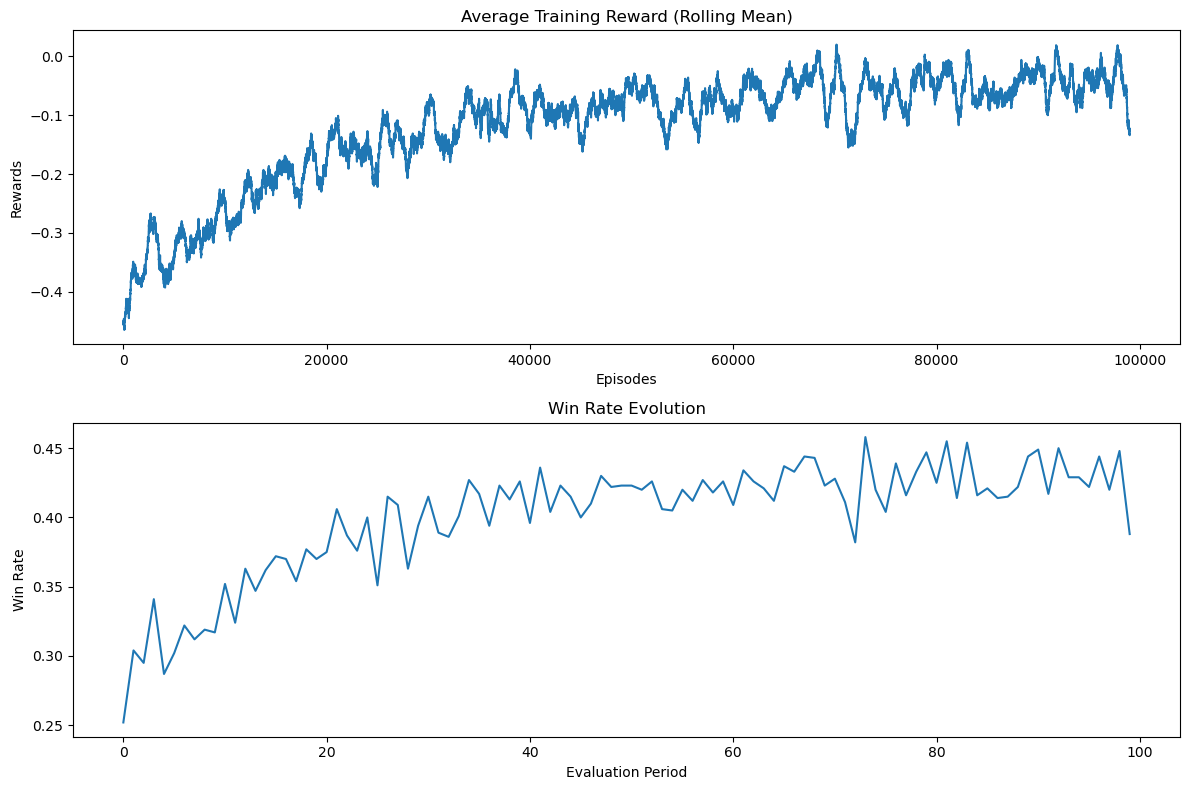

In [42]:
# Sets up the plotting style
# plt.style.use('seaborn')

# Creates a figure with multiple subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plots training rewards
window_size = 1000
rolling_mean = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')
ax1.plot(rolling_mean)
ax1.set_title('Average Training Reward (Rolling Mean)')
ax1.set_xlabel('Episodes')
ax1.set_ylabel('Rewards')

# Plots win rates
ax2.plot(range(len(training_win_rates)), training_win_rates)
ax2.set_title('Win Rate Evolution')
ax2.set_xlabel('Evaluation Period')
ax2.set_ylabel('Win Rate')

plt.tight_layout()
plt.show()

## Evaluating the Trained Agent

Let's evaluate our trained agent's performance over specified number episodes.

In [47]:
n_eval_episodes = 1000              # Number of episodes to run

eval_episode_rewards = []           # Stores rewards per episode during evaluation
eval_episode_steps = []             # Stores steps per episode during evaluation
eval_episode_wins = 0               # Counts wins during evaluation

# Loops over specified number of episodes
for episode in range(n_eval_episodes):
    done = False                            # Tracks the end of the episode
    rewards = 0                             # Accumulates rewards in the episode
    steps = 0                               # Counts steps in the episode

    state, _ = env.reset()                  # Resets the environment to an initial state in every episode

    # Loops until the episode ends
    while not done:
        action = agent.get_action(state)    # Selects action using the agent's policy
        
        next_state, reward, terminated, truncated, _ = env.step(action)     # Takes the action and returns the results

        rewards += reward                   # Accumulates the reward
        steps += 1                          # Increments the step count
        
        done = terminated or truncated      # Episode ends if terminated or truncated

        state = next_state                  # Updates the current state

    eval_episode_rewards.append(rewards)    # Appends the total reward of the episode
    eval_episode_steps.append(steps)        # Appends the total steps of the episode
    eval_episode_wins += (rewards > 0)      # Counts wins during evaluation

    # print(f"Evaluation Episode {episode + 1}: Reward = {episode_rewards}, Steps = {episode_steps}")
    
print(f"\nAverage Rewards: {np.mean(eval_episode_rewards):.2f}")
print(f"Win Rates: {eval_episode_wins/n_eval_episodes:.2f}")



Average Rewards: -0.02
Win Rates: 0.44


In [49]:
env.close()    # Closes the environment to release resources